### Evaluación del modelo en condiciones aproximadas a producción
(estimación de rentabilidad del sistema)

#### Importamos librerías necesarias

In [1]:
import pickle
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests


Cargamos los datos de forecast y las observaciones que hemos usado para entrenamiento, para poder sacar el orden de las columnas

In [2]:
df_observ = pd.read_parquet("../clean/df_definitivo.parquet")

# eliminamos repetidas, columnas que no participan en el modelo
df_observ.drop(columns=['Temperatura', 'wspd'], inplace=True)

df_forecast = pd.read_csv('./clean/forecast_merged.csv')

##### Para mantener el mismo orden de columnas en el input del modelo

In [3]:
antelaciones = df_forecast['antelacion'] # guardamos para evaluar posteriormente
df_forecast = df_forecast[df_observ.columns]

#### Separamos en explicativas y respuesta

In [4]:
X, y_true = df_forecast.drop(columns=['AlturaOlas', 'anio', 'mes', 'dia', 'hora']), df_forecast['AlturaOlas']

#### Cargamos el modelo definitivo

In [5]:
filename = '../modelos/modelo_definitivo/modelo_rf_def.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

model

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


RandomForestRegressor(max_depth=28, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=201, random_state=777)

In [6]:
predicciones = model.predict(X)

In [7]:
calcular_metricas(y_true, predicciones)

{'TEST_MAX_ERROR': 0.6689866587254647,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.19169684838491088,
 'TEST_MEDIAN_ABS_ERROR': 0.10704719974364396,
 'TEST_MEAN_ABS_ERROR': 0.14076525466164974}

Text(0.5, 0, 'TRUE (metros)')

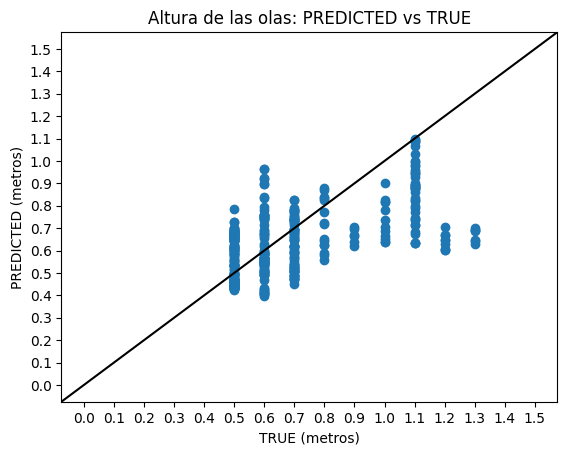

In [8]:
plt.scatter(y_true, predicciones)
plt.axline([0,0], [1.5,1.5], color='0')
plt.xticks([i/10 for i in range(0,16)])
plt.yticks([i/10 for i in range(0,16)])
plt.title('Altura de las olas: PREDICTED vs TRUE')

plt.ylabel('PREDICTED (metros)')
plt.xlabel('TRUE (metros)')

#### Ahora pasaríamos a analizar el error en función de la antelación de la predicción

Text(0.5, 0, 'TRUE (metros)')

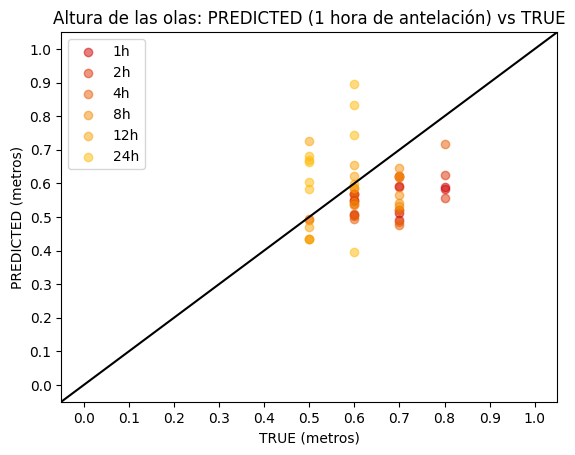

In [9]:
colores = ["#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
hours = [1,2,4,8,12,24]
for i, h in enumerate(hours):
    plt.scatter(y_true[antelaciones == h], predicciones[antelaciones == h], color=colores[i], alpha=0.5, label=f'{h}h')
plt.legend()
plt.xticks([i / 10 for i in range(0, 16)])
plt.yticks([i / 10 for i in range(0, 16)])
plt.axline([0, 0], [1, 1], color='0')
plt.title('Altura de las olas: PREDICTED (1 hora de antelación) vs TRUE')

plt.ylabel('PREDICTED (metros)')
plt.xlabel('TRUE (metros)')